In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

plt.ion()
sns.set( style="white" )

In [2]:
# First make sure our data sets look okay.
from musicml.train.common import load_compressed_pickle
data_sets = load_compressed_pickle( "data_parser/piano-e-competition.pkl.bz2" )

In [3]:
# Setup histogram bins for each source/target sequence.
from musicml.train import midimodel

bins = [0,
    midimodel.VocabularyIndexMap["NOTE_OFF<0>"],
    midimodel.VocabularyIndexMap["TIME_SHIFT<10>"],
    midimodel.VocabularyIndexMap["SET_VELOCITY<0>"],
    len( midimodel.Vocabulary )
]

In [4]:
# Setup up the music generator.
from musicml.generator import MusicGenerator
from musicml.hyperp import Hyperparameters
from musicml.train import midimodel

# Comment out one of these to determine if we run with weights or with no weights.
# Grab the latest weights from the shared google drive.
#weights_path = "20191211-1010.dat"
#weights_path = None
weights_path = "checkpoint.wt"

hyper = Hyperparameters( midimodel.VocabularyLength )
generator = MusicGenerator( hyper, weights_path )

(array([205., 207., 383., 205.]),
 array([  0, 128, 256, 356, 390]),
 <a list of 4 Patch objects>)

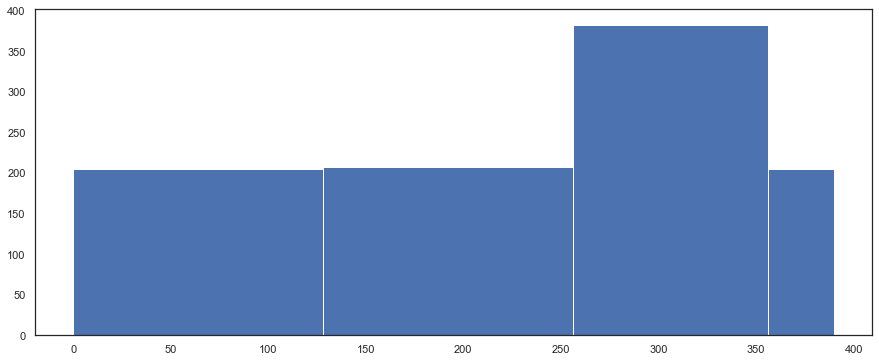

In [5]:
# Test against the first test data set's source sequence.
input_sequence = data_sets["test"][0]["source_sequence"].tolist()
plt.figure( figsize=(15,6) )
plt.hist( input_sequence, bins=bins )

In [6]:
# Run the encoder on the input sequence.
generator.encode_inputs( input_sequence )

In [8]:
generator.model

MusicTransformer(
  (input_embedding): Embedding(
    (embedding): Embedding(390, 512)
  )
  (output_embedding): Embedding(
    (embedding): Embedding(390, 512)
  )
  (encoder): EncoderStack(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): MultiheadAttention(
          (key_trans): Linear(in_features=512, out_features=512, bias=False)
          (value_trans): Linear(in_features=512, out_features=512, bias=False)
          (query_trans): Linear(in_features=512, out_features=512, bias=False)
          (z_softmax): Softmax(dim=-1)
          (z_trans): Linear(in_features=512, out_features=512, bias=False)
        )
        (self_attention_residual): ResidualNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (feed_forward): FeedForward(
          (network): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU

Encoder Layer (Attention Weights) 1


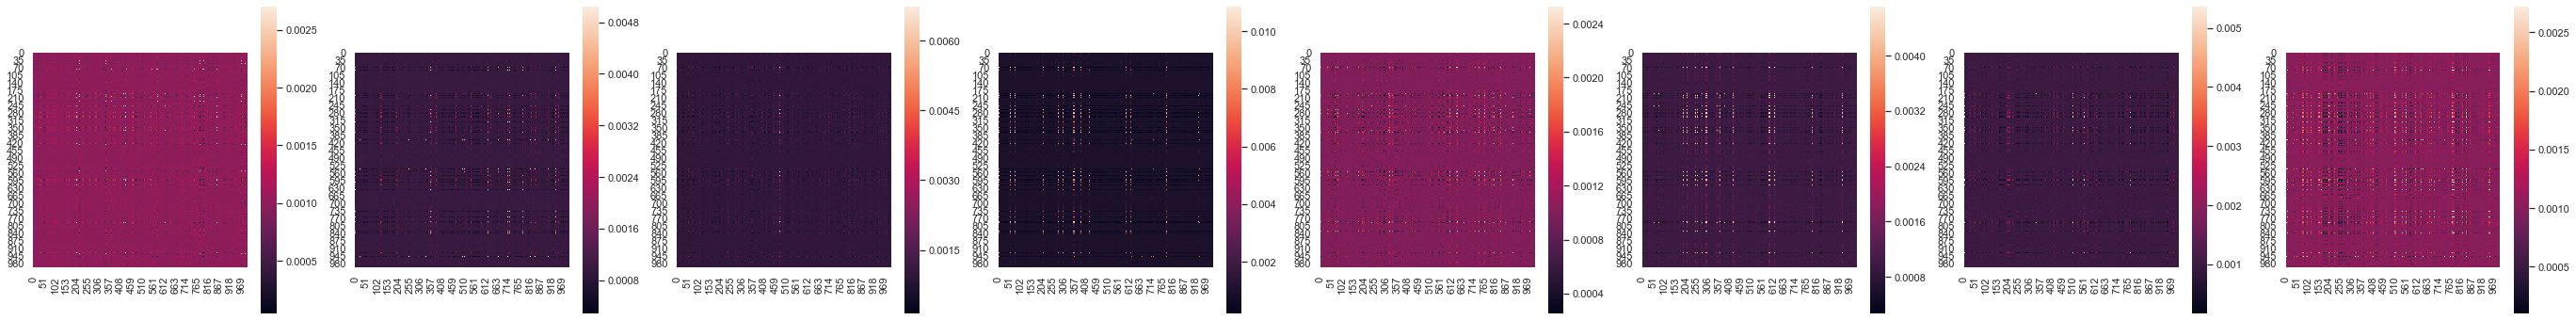

Encoder Layer (Attention Weights) 2


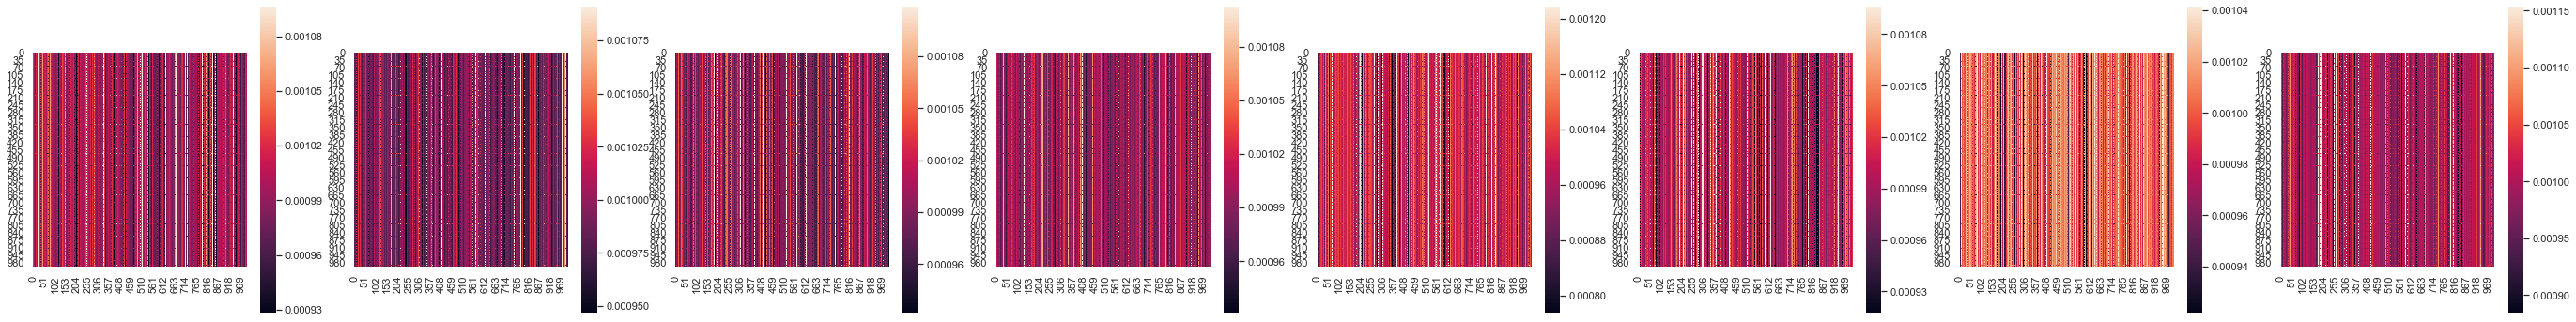

Encoder Layer (Attention Weights) 3


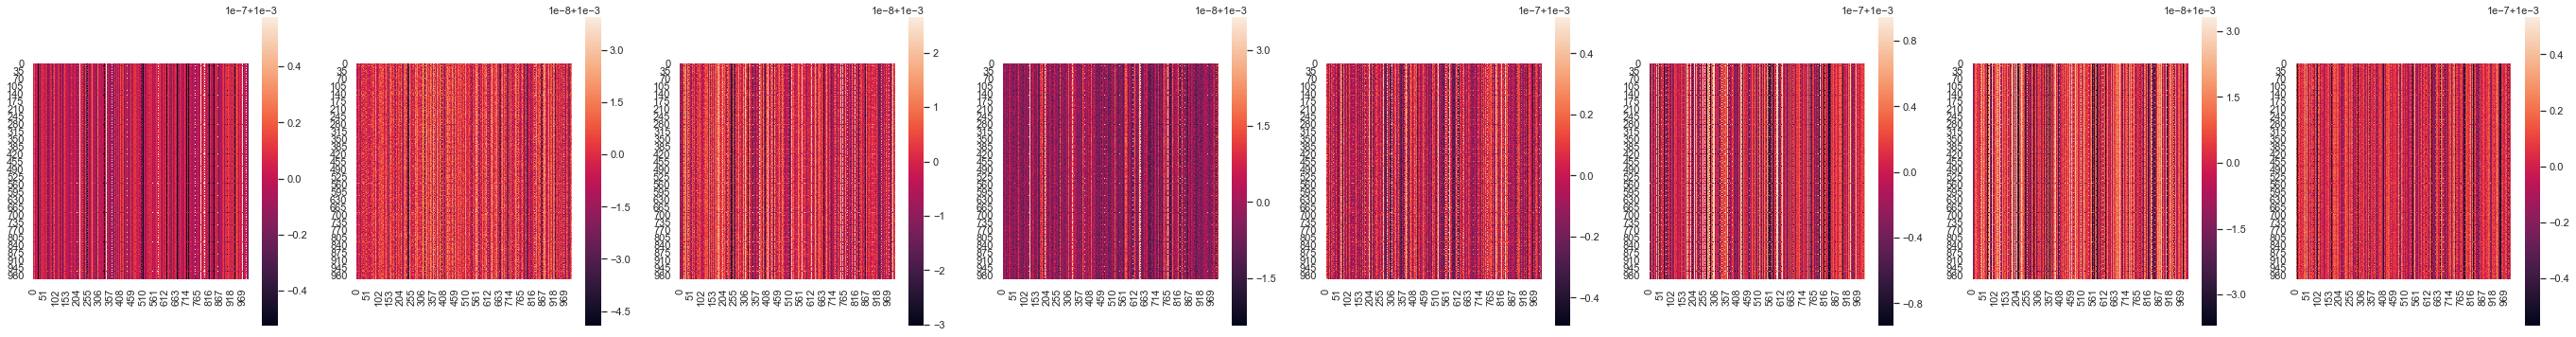

Encoder Layer (Attention Weights) 4


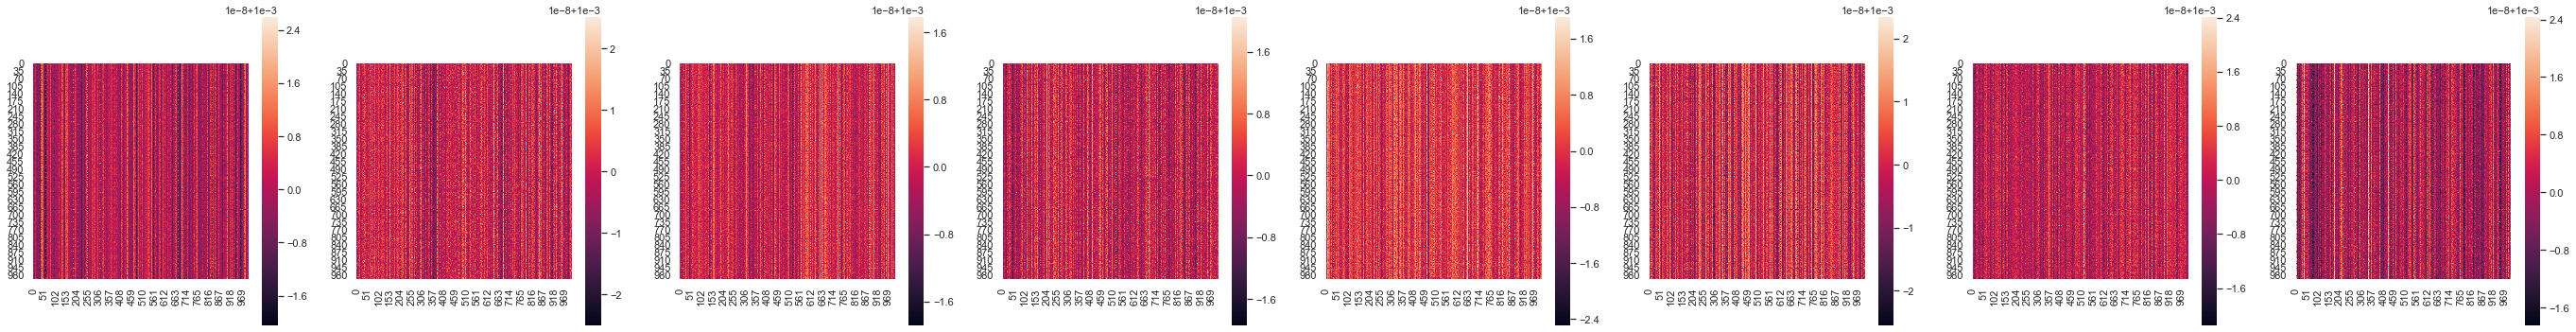

Encoder Layer (Attention Weights) 5


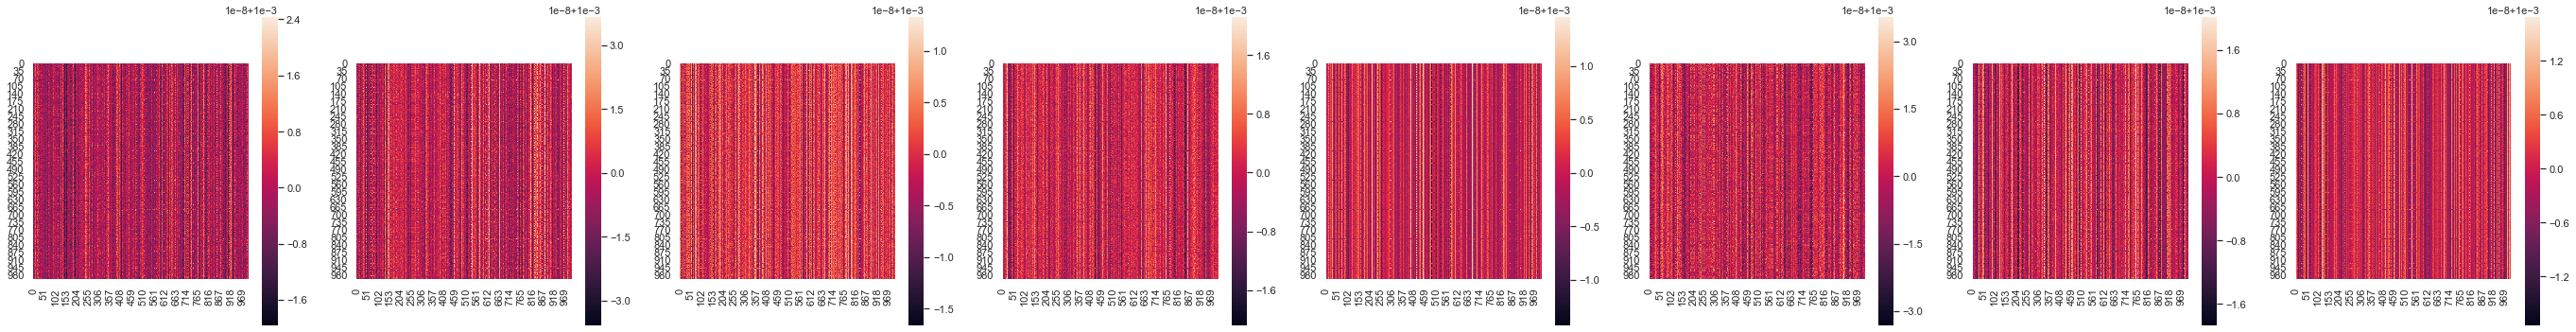

Encoder Layer (Attention Weights) 6


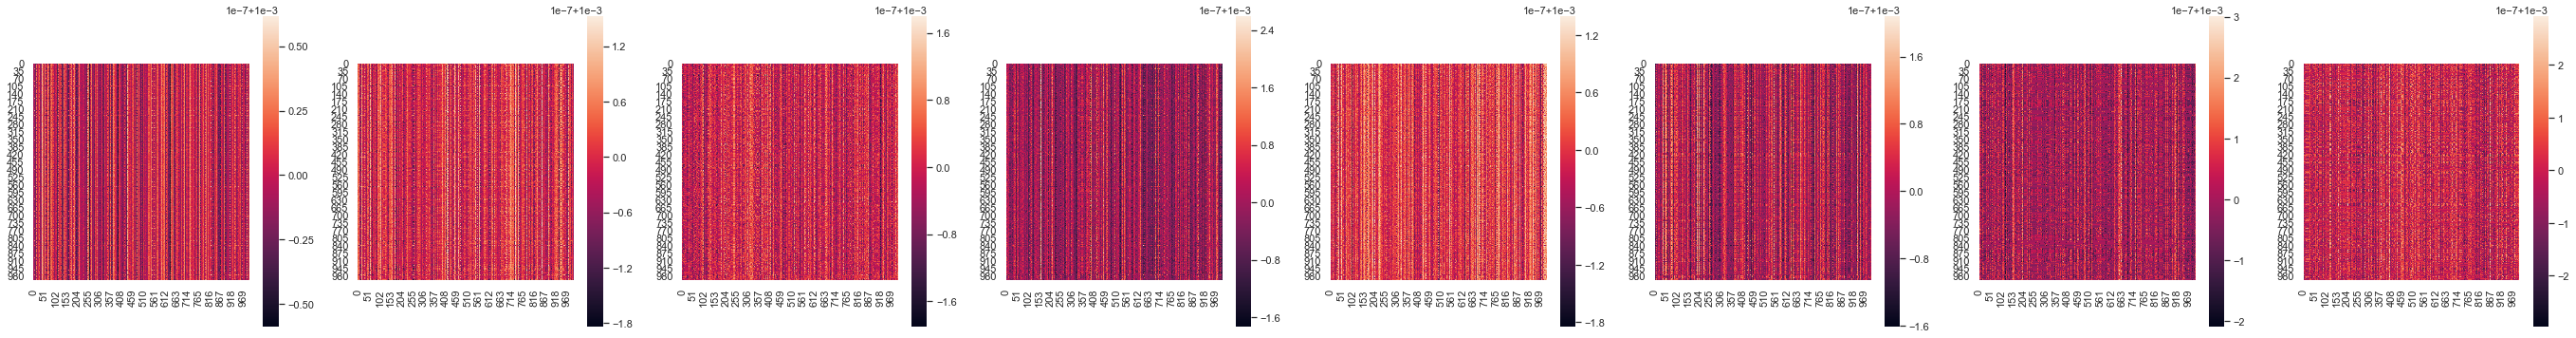

In [7]:
# Plot the encoder's attention weights (after softmax) for each attention head.
number_layers = len( generator.model.encoder.encoder_layers )
for layer_idx, layer in enumerate( generator.model.encoder.encoder_layers ):
    number_heads = layer.self_attention.number_heads
    _, axes = plt.subplots( 1, number_heads, figsize=(number_heads * 6, 6) )

    print( f"Encoder Layer (Attention Weights) {layer_idx + 1}" )
    for head_idx in range( number_heads ):
        att_w = layer.self_attention.attention_weights[head_idx].cpu()
        sns.heatmap( att_w, square=True, ax=axes[head_idx] )
    plt.show()

In [ ]:
# Plot the encoder's relative logits (before softmax) for each attention head.
number_layers = len( generator.model.encoder.encoder_layers )
for layer_idx, layer in enumerate( generator.model.encoder.encoder_layers ):
    number_heads = layer.self_attention.number_heads
    _, axes = plt.subplots( 1, number_heads, figsize=(number_heads * 6, 6) )

    print( f"Encoder Layer (Relative Logits) {layer_idx + 1}" )
    rel_logits = layer.self_attention.relative_logits.cpu()
    for head_idx in range( number_heads ):
        sns.heatmap( rel_logits[head_idx], square=True, ax=axes[head_idx] )
    plt.show()

In [ ]:
# Plot the encoder's invariant logits (before softmax and relative logits are added) for each attention head.
number_layers = len( generator.model.encoder.encoder_layers )
for layer_idx, layer in enumerate( generator.model.encoder.encoder_layers ):
    number_heads = layer.self_attention.number_heads
    _, axes = plt.subplots( 1, number_heads, figsize=(number_heads * 6, 6) )

    print( f"Encoder Layer (Invariant Logits) {layer_idx + 1}" )
    invariant_logits = F.softmax( layer.self_attention.invariant_logits.cpu(), dim=-1 )
    for head_idx in range( number_heads ):
        sns.heatmap( invariant_logits[head_idx], square=True, ax=axes[head_idx] )
    plt.show()

In [ ]:
# Plot the output of the encoder.
sns.set_style( "dark" )
plt.figure( figsize=(30, 8) )
plt.imshow( generator.model.encoder_output.data.cpu(), aspect="auto", cmap="Greys" )
plt.colorbar()

In [ ]:
# Initialize the decode run.
decoder = generator.decode_outputs( midimodel.StartTokenIndex, midimodel.StopTokenIndex )

In [ ]:
# Decode the next output token.
next_output, next_scores = next( decoder )
print( next_output )
print( midimodel.Vocabulary[next_output] )

In [ ]:
# Plot the probability distribution across the vocabulary of the latest output probabilities.
next_probs = F.softmax( next_scores, dim=0 )
plt.figure( figsize=(15, 5) )
plt.plot( list(range(midimodel.VocabularyLength)), next_probs.cpu() )

In [ ]:
# Verify back to back runs of the encoder produce the same output.
generator.encode_inputs( input_sequence )
en1 = generator.model.encoder_output.data.cpu()
generator.encode_inputs( input_sequence )
en2 = generator.model.encoder_output.data.cpu()
(en1 == en2).all()

In [ ]:
# Compare the differences in output scores (and their softmaxes) between two consecutive decode runs.
no1, ns1 = next( decoder )
no2, ns2 = next( decoder )

plt.figure( figsize=(15,8) )
plt.imshow( (ns1 - ns2).view(1, -1).cpu(), aspect="auto" )
plt.colorbar()

plt.figure( figsize=(15,8) )
plt.imshow( (F.softmax(ns1, dim=-1) - F.softmax(ns2, dim=-1)).view(1, -1).cpu(), aspect="auto" )
plt.colorbar()

In [21]:
import torch
import torch.nn as nn
import musicml.modules.attention as ml

mha_nn = nn.MultiheadAttention( 3, 1, bias=False )
mha_ml = ml.MultiheadAttention( 3, 1 )

x = torch.randn( 3, 3 )
xx = x.unsqueeze( 1 )

print( x )
print( xx )

tensor([[ 0.0025,  1.1052, -1.2379],
        [-1.2230,  0.2558, -2.0142],
        [ 0.7788, -0.7054,  1.2240]])
tensor([[[ 0.0025,  1.1052, -1.2379]],

        [[-1.2230,  0.2558, -2.0142]],

        [[ 0.7788, -0.7054,  1.2240]]])


In [16]:
ident = torch.tensor( [[1, 2, 3,], [1, 2, 3], [1, 2, 3]] ) #torch.eye(3)
mha_nn.in_proj_weight.data = torch.cat( (ident, ident, ident), dim=0 )
mha_nn.in_proj_weight

Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True)

In [12]:
mha_nn.out_proj.weight.data = ident
mha_nn.out_proj.weight

Parameter containing:
tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]], requires_grad=True)

In [13]:
mha_ml.key_trans.weight.data = ident
mha_ml.value_trans.weight.data = ident
mha_ml.query_trans.weight.data = ident
mha_ml.z_trans.weight.data = ident

In [14]:
yy = mha_nn( xx, xx, xx )
y = mha_ml( x, x )

print( yy )
print( y )

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'mat2' in call to _th_mm

In [22]:
import torch
import torch.nn as nn
import musicml.modules.attention as ml

mha_nn2 = nn.MultiheadAttention( 4, 2, bias=False )
mha_ml2 = ml.MultiheadAttention( 4, 2, key_size=2, value_size=2 )

x2 = torch.randn( 4, 4 )
xx2 = x2.unsqueeze( 1 )

print( x2 )
print( xx2 )

tensor([[-1.0443, -0.8864,  0.9148, -1.9106],
        [ 1.4289,  1.5797,  1.3851, -1.6351],
        [-0.5858,  0.1526,  1.8286,  0.2743],
        [ 0.6825, -1.8639,  0.2686,  0.5239]])
tensor([[[-1.0443, -0.8864,  0.9148, -1.9106]],

        [[ 1.4289,  1.5797,  1.3851, -1.6351]],

        [[-0.5858,  0.1526,  1.8286,  0.2743]],

        [[ 0.6825, -1.8639,  0.2686,  0.5239]]])


In [23]:
ident2 = torch.tensor( [[1, 2, 3, 4.], [1, 2, 3, 4.], [1, 2, 3, 4.], [1, 2, 3, 4.]] ) #torch.eye(4)
mha_nn2.in_proj_weight.data = torch.cat( (ident2, ident2, ident2), dim=0 )
mha_nn2.in_proj_weight

Parameter containing:
tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]], requires_grad=True)

In [24]:
mha_nn2.out_proj.weight.data = ident2
mha_nn2.out_proj.weight

Parameter containing:
tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]], requires_grad=True)

In [25]:
mha_ml2.key_trans.weight.data = ident2
mha_ml2.value_trans.weight.data = ident2
mha_ml2.query_trans.weight.data = ident2
mha_ml2.z_trans.weight.data = ident2

In [26]:
yy2 = mha_nn2( xx2, xx2, xx2 )
y2 = mha_ml2( x2, x2 )

print( yy2 )
print( y2 )

(tensor([[[-77.1485, -77.1485, -77.1485, -77.1485]],

        [[ 63.0237,  63.0237,  63.0237,  63.0237]],

        [[ 63.0238,  63.0238,  63.0238,  63.0238]],

        [[-50.5055, -50.5055, -50.5055, -50.5055]]],
       grad_fn=<UnsafeViewBackward>), tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 1.3394e-36],
         [1.0800e-19, 2.8396e-06, 1.0000e+00, 1.8941e-09],
         [0.0000e+00, 1.3559e-16, 1.0000e+00, 1.1142e-25],
         [7.1225e-01, 9.4441e-02, 4.0971e-02, 1.5234e-01]]],
       grad_fn=<DivBackward0>))
tensor([[-77.1485, -77.1485, -77.1485, -77.1485],
        [ 63.0237,  63.0237,  63.0237,  63.0237],
        [ 63.0238,  63.0238,  63.0238,  63.0238],
        [-50.5054, -50.5054, -50.5054, -50.5054]], grad_fn=<MmBackward>)
